# Data Integration and Quality Assurance of Sequencing Metadata in

Washington State

Frank Aragona  
Cory Yun  
Philip Crain  
Paul Lloyd  
Emily Nebergall  
Cameron Ashton  
Peter J Gibson  
Marcela Torres  
Lauren Frisbie  
Allison Warren  
Laura Beilsmith  
Xichi Zhang  
Allison Thibodeau  
Sarah Jinsiwale  
Topias Lemetyinen  
Alli Black  
Alex Cox  
March 4, 2024

Genomic surveillance is important for identifying and tracking SARS CoV-2 variants to better mitigate spread of COVID-19. Washington State Department of Health quickly increased capacity to surveil SARS CoV-2 variants by partnering with over 25 labs to collect sequencing data while developing and implementing solutions to standardize submissions and enhance data linkage and quality. High impact solutions included development of a standardized reporting template, collection of case demographics, adaptation of HL7 messages with sequencing data, and strategic utilization of external sequencing data repositories. We developed an automated pipeline that combines data science tools to ingest, clean, and link SARS CoV-2 sequencing data from multiple sources, while accounting for differing data formats and quality. This manuscript details the first version of the pipeline developed in February 2021 when processes were unstable and were being developed as they were utilized.

# Introduction

This manuscript documents the original data integration pipeline for SARS-CoV-2 sequences for Washington State Department of Health during early 2021 to mid 2023. The Sequencing project began in February 2021 as an effort to process sequencing data into the Washington State Disease Reporting System (WDRS). In turn, the data fuels SARS-CoV-2 variant tracking and the generation of Covid-19 reports which are disseminated to the highest levels of state government. The pipeline continuously links data to our main database WDRS, where the data can be used to gain insights via surveillance reports or research (for example, see [Oltean et al. n.d.](#ref-olteanSentinelSurveillanceSystem); [Oltean et al. 2024](#ref-olteanChangingGenomicEpidemiology2024); [Wagner et al. 2023](#ref-wagnerPositiveSelectionUnderlies2023)). Data are processed via numerous R/Python/SQL scripts and are uploaded via rosters (.csv files) into WDRS and our Molecular Epidemiology produces [reports](https://doh.wa.gov/sites/default/files/2022-02/420-316-SequencingAndVariantsReport.pdf) with the data. These processes ebb and flow often as changes are needed regularly in response to the data that are received. Since mid 2023 we have stopped using this particular pipeline and have built a new pipeline using a more streamlined approach. The purpose of detailing the original pipeline in this document is to give a transparent look at how data were processed under the unusual circumstances during the COVID-19 pandemic. Many aspects of this pipeline are inefficient because it was built under a rapidly changing environment, one that had never been built before, in addition to the many time constraints placed on our teams to produce data reports quickly. Some of the inefficiencies exposed in this pipeline still exist with our newer pipelines, but our teams are working to build a more sustainable way to process sequencing data of any disease type.

There are a multitude of barriers which make data processing difficult with any pipeline such as:

1.  Data standardization; data are received multiple ways. Depending on the manner it is submitted it may not follow the standard format requested from submitters. This requires manual intervention or communication back to labs. In addition, some submitters cannot change the manner in which they submit data which makes standardization across all labs impossible. These are handled by separate processes. Occasionally, submitters may break consistency in their own manner of which they report as well.
2.  Data quality; the quality of data received from labs can vary dramatically. Data needs to match between three sources: Lab Submissions, WDRS, and GISAID. When the wrong data are sent this can make matching impossible and prevents records from making it into our systems. It has been found that submitters sometimes submit incorrect ACCESSION ID’s that are used to match records between systems. Without the correct data it requires a considerable amount of manual intervention to be able to roster those records. Additionally, there are considerable lag times between all three data points/repositories; when a record is submitted that are not within WDRS the records cannot be matched and rostered.
3.  Technological gaps; the COVID-19 pandemic has exposed many technological gaps in our public health disease surveillance systems. Much of the technology used for processing and storing data needed to be built out during early 2020 so that we could provide disease reports in a timely manner. Therefore a lot of processes like this pipeline were built for short term needs, adding on more and more ‘technological debt’. Short term solutions have consequences and our data infrastructure is not well suited for pipelines like this.

The original pipeline aggregates sequencing data submitted via secure file transfer, electronic lab reporting, lab management software, and open access data repositories. The process incorporates robust solutions to data challenges, including lagged data availability, variable data formatting, record duplication, and missing data. After aggregation, the pipeline connects records to COVID-19 case data via sequence to diagnostic test identifiers. We used patient demographics and string matching to link sequences to cases that are missing the unique identifiers. Internal databases are compared to external repositories to identify new results, track missing data, onboard new sequencing partners, and validate data. This pipeline was able to mostly automate aggregation, cleaning, and linkage of SARS CoV-2 genomic surveillance data, minimizing manual work and hastening availability of data for analysis and reporting.

Challenges remain despite these improvements in data standardization and management. Barriers include differences in HL7 message reporting capabilities among submitters, inconsistencies in virus naming conventions, challenges in pulling data from public repositories, and limitations within our current internal database infrastructure. These factors increase likelihood of errors, require data processing logic unique to individual submitters and require manual intervention. Continued development of national standards can address these issues. Data accessibility can be improved by encouraging open-source sharing, especially to repositories that enable full programmatic data sourcing for all users. A community of practice across departments of health to discuss storage methods, processing pipelines, and matching approaches would enhance current practices, and support greater consistency and interoperability across public health.

## Timeline

timeline
 title Timeline of Covid-19 Sequencing Efforts
 2021 : Feb - Sequencing Project Begins
 : April - Access to StarLIMS
 : July - Template disseminated
 : Sep - Reporting via HL7/ELR goes live
 2022 : April - DSSU-DIQA handoff
 : Sep - PGCOE grant awarded
 : Nov - Sequencing 2.0 dev begins
 2023 : Mar - Sequencing 2.0 testing begins
 : June - Sequencing 2.0 is deployed
 : Aug - Sequencing 3.0 planning begins
 2024 : Jan - Exploration of cloud computing for the pipeline

The sequencing metadata linkage project began in February 2021 by the Data Science Support Unit (DSSU). A pipeline was needed to process and upload sequencing data to Washington Disease Reporting System (WDRS) for variant tracking/generation of reports to the governor’s office​. The pipeline links sequencing metadata to case data in WDRS, links sequences to GISAID (Global Initiative on Sharing All Influenza Data, a public sequencing repository), and it cleans and transforms non-standardized data.

The project originally started as a group of individual contributors writing R scripts to handle needs for pulling data and cleaning, matching, and transforming non-standardized sequencing data​. During this period, urgency was prioritized at the cost of technical debt: it was a “build as we go”​ mentality given the time restraints during the pandemic. This scenario made for segmented processes and no true workflow. During height of the 2021-2022 period this pipeline would typically process 1000+ records per week​.

# General Overview

Sequencing data gets sent through our pipeline through multiple processes and the pipeline works in the following steps:

1.  A submitter sends us the sequencing data three different ways;
    -   as tabular data via secure file transfer (SFT)
    -   as tabular data that is ‘scraped’ web-scraping of their dashboard as is the case with our PHL
    -   via ELR or electronic lab reporting that is automatically connected to our database
2.  Our pipeline will extract, transform, and link that data to a case in WDRS
3.  The pipeline then performs quality checks to make sure errors or data leaks did not occur

The three main routes that a submitter can send us data through are detailed in <a href="#fig-overview" class="quarto-xref">Figure 1</a> under Template Submitters (secure file transfer of tabular data), PHL (webscraping of tabular data), and HL7 messages (secure data transfer for ELR).

First, the [Template Submitters](@sec-template) script processes the majority of data received by external submitters. Sequencing data from external submitters are received via `.csv` files in a template format which they uploaded to our secure file transfer (SFT) portal.

Second, the The [PHL Roster](@sec-phl) script processes the data received from PHL (Public Health Laboratory), our internal laboratory. Sequencing data from PHL is pulled from an internal dashboard, ‘StarLIMS’. The logic for both processes are similar. There is an attempt to link the sequencing data to the patient-level data using a `SEQUENCE_CLINICAL_ACCESSION`; an accession ID that should match between the patient-level data and the specimen sequenced by laboratories (note: while the terms ‘Laboratory’ and ‘Submitter’ may be used interchangeably at times they are not the same). In many cases, this accession ID is unable to match. This may be due to multiple reasons ranging from lag times to data quality issues. In this case, if demographics have been provided by the submitter an attempt will be made to match based on these demographic variables (name, date of birth, etc.).

Lastly, the [ELR Roster](@sec-elr) script processes the data from external submitters that have been received via HL7 messages and populated in the table in WDRS named `[dbo].[DD_ELR_DD_ENTIRE]`. In this case, the ELR (electronic laboratory reporting) process performs the matching of sequencing data to the patient-level data. Since the sequencing data and patient-level data are already tied for these records received via ELR, the logic for the ELR Roster script is predominately transformation to a format acceptable for import into the `[dbo].[DD_GCD_COVID_19_FLATTENED]` table. All records, regardless of the process through which they are received/processed are uploaded to the `[dbo].[DD_GCD_COVID_19_FLATTENED]` table via .csv files in a roster format. These rosters are the end product and output of all three processes.

<figure id="fig-overview">
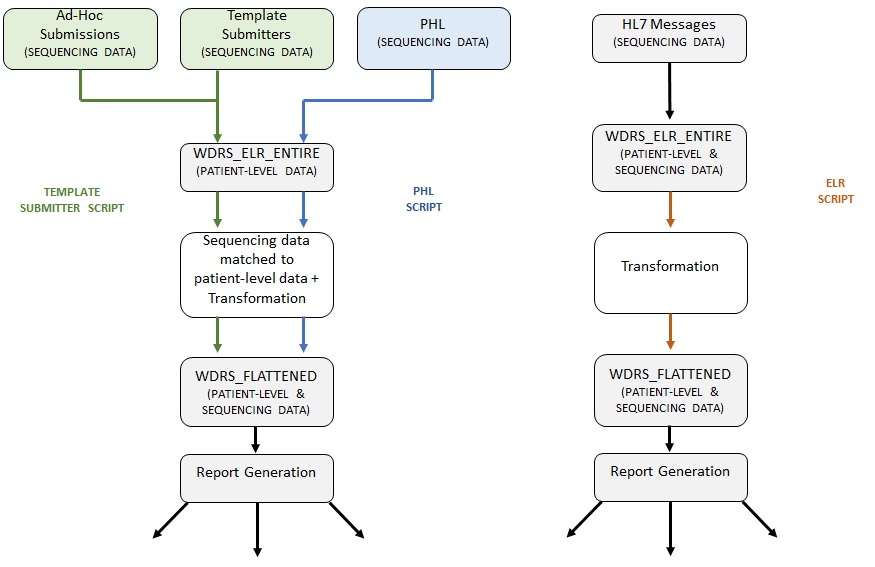
<figcaption>Figure 1: Overview of sequencing pipeline</figcaption>
</figure>

In addition to sequencing data submissions and WDRS, there is a third component; GISAID (Global Initiative on Sharing Avian Influenza Data). GISAID is an initiative that provides open-access to genomic data of influenza viruses and more importantly for the purposes of this project, SARS-CoV-2; coronavirus responsible for the COVID-19 pandemic). This database is available online to the public and holds genomic data of sequenced specimens from across the globe. In theory, submitters should be sending their sequencing data to the DOH and GISAID. When this happens there is consistency between both databases and the data received from submitters <a href="#fig-gisaid" class="quarto-xref">Figure 2</a>

<figure id="fig-gisaid">
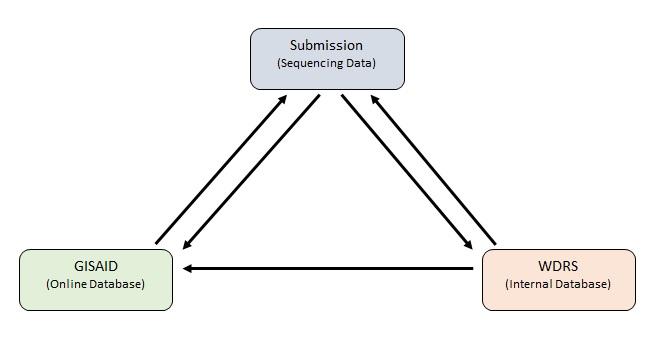
<figcaption>Figure 2: Sequence submissions should match WDRS and GISAID</figcaption>
</figure>

It should be noted that in some instances sequencing data is manually entered by creating events within WDRS. However, this practice is not common and generally should be avoided if at all possible in order to prevent non-standard entries and potential data quality issues.

## Laboratories and Submitters

Through various contracts and collaboration with external agencies the DOH receives sequencing data from numerous submitters. Laboratories are the entities which perform the sequencing. Submitters are the entities that relay/send sequencing data to the DOH. Many of our submitters perform both the sequencing and submission of data. There are some submitters that send sequencing data to the DOH on behalf of multiple laboratories as well. Therefore, some laboratories that perform the sequencing do not directly submit the sequencing data themselves. Data quality is a significant issue across all submission routes listed below. This is mainly due to the fact that there are no national standards as how sequencing data should be transmitted.

## External Dependencies and Data Pulls

Prior to any processing of sequencing data received from submitters there are numerous data pulls and external dependencies that must be completed. Below is a brief description of each process <a href="#fig-pulls" class="quarto-xref">Figure 3</a>.

<figure id="fig-pulls">
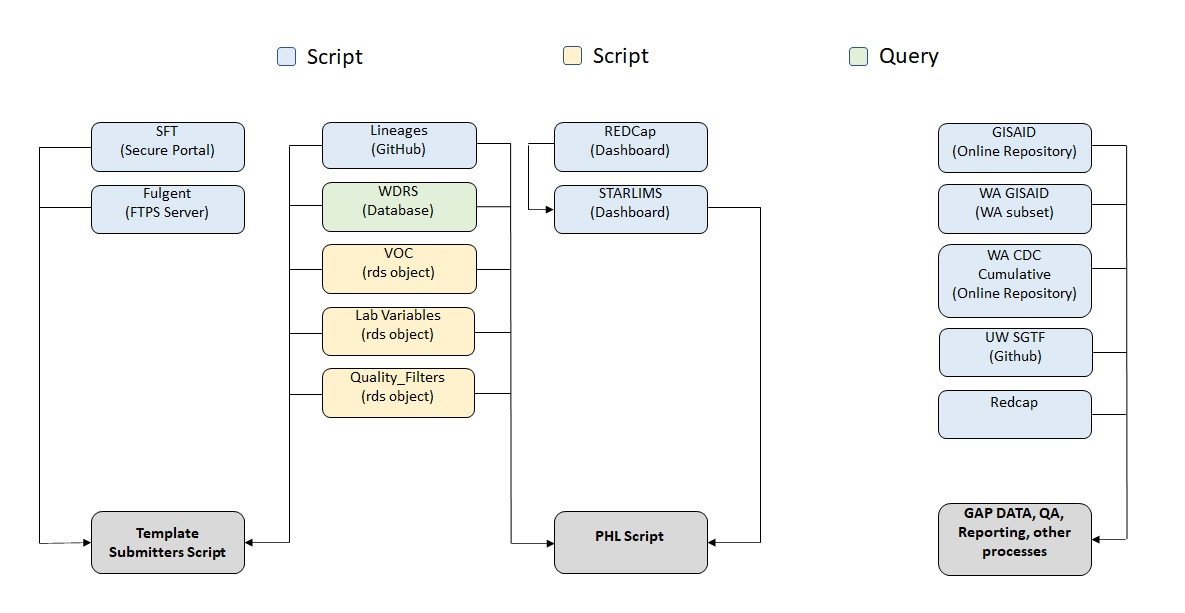
<figcaption>Figure 3</figcaption>
</figure>

The scripts below are responsible for pulling submissions from their corresponding locations and dropping a file into the submissions folder in the Network Drive so that it can be picked up by the roster scripts and processed into WDRS.

### Data Pulls

**sel_Dashboard_All.Rmd** performs the task of pulling data from across three separate dashboard within starLIMS. This data is aggregated then placed into the submission folder for PHL in the network drive for processing.

**sft_main.py** performs the task of pulling all data from the individual submitter folders within the SFT, routing the downloaded files to the correct submitter folders in the network drive, deleting out the old files, and keeping a log. Additionally, an email is sent out to the correct stakeholders each day on what submission were uploaded to the SFT (if any) and notifies of any new labs that have uploaded a submission for the first time.

### External Processes

**wa_cdc_pull.Rmd** performs the task of pulling data from the CDC for specimens sequenced by laboratories under the CDC for the state of Washington so that it can be picked up by multiple QA scripts and utilized by other other stakeholders.

**lineages_main.py** performs the task of pulling data from a .txt in a GitHub repository containing the latest Covid Lineages and dropping them in the lineages folder in the network drive so that it can be picked up by multiple scripts and utilized by other stakeholders. The .txt file in the repository is the same file used update the Cov-Lineages site (<https://cov-lineages.org/lineage_list.html>).

#### SGTF

To assist with the monitoring of Omicron, five labs are submitting S-gene target failures (SGTF) data to WADOH via Redcap or GitHub (UW only). These submissions are standardized and compiled each day to calculate % SGTF by epidemiological week.

**sgtf_compile_daily.Rmd** performs the task of compiling all the templates and performing the necessary calculations. Submissions are downloaded by Molecular Epi each day and placed into the network drive to be picked up by sgtf_compile_daily.Rmd

**uw_sgtf.Rmd** performs the task of pulling the latest SGTF file from UW’s GitHub repository, routing the downloaded files to the correct folder in the Network Drive, and keeping a log.

## Example Datasets

In 2021, data was sent from sequencing labs to us via tabular files. There were no standards between submitting labs, and for a given submitter the format of the tabular files would often change between each submission as well​. It was impossible to process these data without editing scripts each time to account for a varying format. Initially, all data was received via non-standardized tabular files, including data sent from our public health lab (PHL). We did not have access to their starLIMS database at the time. <a href="#tbl-tabdata1" class="quarto-xref">Table 1</a> below is an example of the data sent to us in tabular format. <a href="#tbl-tabdata2" class="quarto-xref">Table 2</a> shows data sent in tabular form from our public health laboratory (PHL) and <a href="#tbl-tabdata3" class="quarto-xref">Table 3</a> is an example of data sent from the University of Washington Virology Lab (UW Virology).

| Variable              | Description                                     |
|-----------------------|-------------------------------------------------|
| Accession             | identifier that links a sequence to a test      |
| COLLECTION_SAMPLE_ID  | the identifier that linked a sequence to a test |
| ORIG_ACCESSION_NUMBER | the identifier that linked a sequence to a test |
| PAT_FIRST_NAME        | patient first name                              |
| PAT_LAST_NAME         | patient last name                               |
| DATE_OF_BIRTH         | date of birth                                   |
| PAT_ADDRESS_1         | address                                         |
| PAT_CITY              | city                                            |
| PAT_STATE             | state                                           |
| PAT_ZIP               | zip code                                        |
| Phone                 | phone number                                    |
| Original Physician    | doctor name                                     |

Table 1: example of tabular datasets sent to the Department of Health from sequencing labs in 2021

| Variable               | Description                                           |
|--------------------------|----------------------------------------------|
| LIMS                   | the laboratory information management system (LIMS)   |
| Project                | the reason for sequencing                             |
| Investigator_sample_id | an identifier to the sample                           |
| collection_date        | the specimen collection date                          |
| age                    | patient age                                           |
| county                 | patient county                                        |
| sex                    | patient sex                                           |
| specimen_id            | the identifier linking to the original PCR covid test |
| submitting_lab         | the lab submitting the sequence                       |
| note                   | free text note field                                  |

Table 2: example of tabular datasets sent to the Department of Health from a Public Health Lab (PHL) during 2021

| Variable        | Description                                                                                |
|--------------------------|----------------------------------------------|
| uwnum           | the identifier of the sequence that links to GISAID                                        |
| acc_num         | the accession number linking to the positive covid PCR test                                |
| collection date | specimen collection date                                                                   |
| loc_state       | patient state                                                                              |
| fullname        | the full GISAID identifier name, such as HCoV19-USA/WA-#####/2021 (not the patient’s name) |
| shortname       | a partial GISAID identifier name, such as WA-#######                                       |

Table 3: example of tabluar datasets sent to the Department of Health by UW Virology during 2021

As you can see from the tables above, data sent via tabular format early in the project was not standardized and could not be processed automatically due to it constantly changing field names and descriptions.

# Roster Workflows

There are three main workflows for rostering sequencing data into WDRS. [ELR](@sec-elr), [PHL](@sec-phl), and [Template](@sec-template) scripts as detailed in <a href="#sec-overview" class="quarto-xref">Section 2</a>. All three will output a roster, and the [Roster Compile](@sec-rostercompile) script will combine them and send the data to be rostered into WDRS. See <a href="#fig-roster" class="quarto-xref">Figure 4</a> for a high level overview. The [elr.Rmd](notebooks/elr.Rmd) script pulls sequencing metadata from WDRS, transforms it, and runs QA checks on it before putting it into a usable roster. [template_submitters.Rmd](notebooks/template_submitters.Rmd) performs the task of processing template submission. [PHL.Rmd](notebooks/phl.Rmd) performs the task of processing all phl records. Both the template and phl processes operate based on similar logic from a high level view, but there are significant differences between each script.

The `SEQUENCE_CLINICAL_ACCESSION` variable is used to find a matching event within the `[dbo].[DD_ELR_DD_ENTIRE]` table. The `CASE_ID` (WDRS variable that is an identifier for a disease case, not a person) for that event is pulled then assigned to the corresponding record. At this point, if an event using the accession ID cannot be found for a record it will be routed to two different processes depending on if the sequencing data received has patient demographics attached to it; FIRST_NAME, LAST_NAME, MIDDLE_NAME, DOB. If the record received contains patient demographic it is routed to the [fuzzy matching process](notebooks/fuzzy.Rmd), an attempt to match to the correct event will be made using the demographic information. If the record received contains no patient demographic it is routed to the keep na process (<a href="#sec-keepna" class="quarto-xref">Section 3.4</a>), the record will be retained and an attempt to match via the accession ID will regularly be made in case the corresponding event populates in WDRS later on.

Once a record has been matched to an event it will undergo transformation to clean and standardize the matched data into a roster format. Some submitters do not provide the full `GISAID_ID` in the submission. In this case, the `SEQUENCE_ACCESSION` can be constructed from their internal accession is inputted into the `GISAID_ID` column. This happens during the transformation process and the resulting `SEQUENCE_ACCESSION` should match to what is in GISAID.

Records are then put through a series of quality filters to check for QA issues. All records that pass this series of QA checks will then populated into a final roster then outputted to be picked up by the roster compile script <a href="#sec-rostercompile" class="quarto-xref">Section 3.1.4</a> and sent to data support for upload to WDRS.

<figure id="fig-roster">
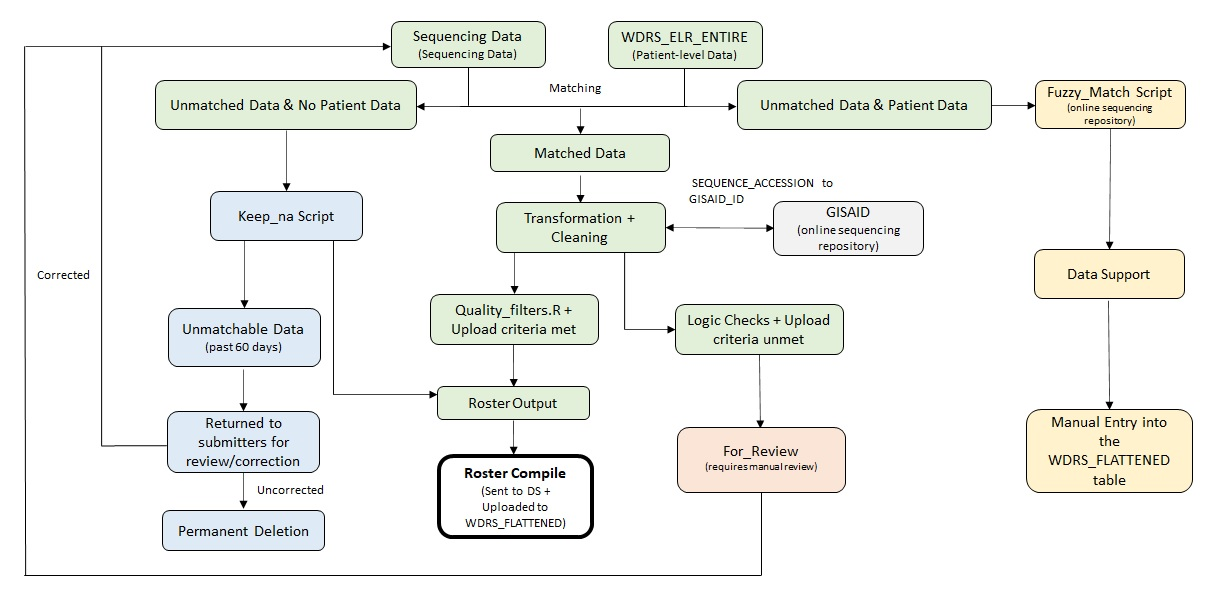
<figcaption>Figure 4</figcaption>
</figure>

## Roster Scripts

This section gives more details about each roster script and a high level diagram following the process.  

Legend:

%%{ init: { 'flowchart': { 'curve': 'monotoneY' } } }%%
flowchart TD
 ext(External Data Owner) 
 doh[/Internal Data Owner/]

%%{ init: { 'flowchart': { 'curve': 'monotoneY' } } }%%
flowchart TD
 proc[["Data processing (software)"]]
 script{{"Data processing (scripts)"}}
 db[(Database)]

### ELR

Electronic Lab Reporting for sequencing went live in September 2021. These are records with Covid PCR tests processed by WELRS/DRIVE and sent to WDRS​. See <a href="#fig-elrflow" class="quarto-xref">Figure 5</a> below. For more details on the script, see [the ELR notebook](notebooks/elr.Rmd). From a high-level overview, the script will:

-   WELRS/DRIVE process, match, and fill the entire/lab tables but not sequencing table​
-   No QA processing​
-   Sequencing table is built as an after thought​
-   WELRS/DRIVE is somewhat of a black box to us (changes without knowing, don’t have oversight on mismatches)​
-   Our ELR script will extract from the entire table, transform, QA, and send via roster​

%%{ init: { 'flowchart': { 'curve': 'monotoneY' }, 'theme':'base', 'themeVariables': {'primaryColor': '#eff6f3', 'primaryTextColor': '#6a6a6a', 'primaryBorderColor': '#6a6a6a', 'lineColor': '#f3969a', '#seondaryColor': '#eff6f3'}} }%%
 flowchart TD
 d_lab(Diagnostic Lab) --> s_lab(Sequencing Lab)
 s_lab & lab(Diagnostic & Sequencing Lab) --> aphl(APHL) 
 s_lab --> pre[[Pre-processor]]
 aphl --> pre
 lab --> pre
 pre --> welrs[(WELRS)] --> drive[[DRIVE]] --> post[[Post-processor]] --> wdrs[(WDRS)]
 post --> welrs
 wdrs --> diqa{{"Data Integration Pipeline:
 - Data Reformatting
 - Public Repo (NCBI/GISAID) Linkage
 - QA"}}
 diqa --> |"Question 
 Package 
 Update"| wdrs

### PHL

Access to starLIMS, our Public Health Laboratory (PHL) system, was granted in April 2021. However, there was no API or underlying database access so the pipeline needed to scrape data from the starLIMS dashboard. It would download the `.xslx` files from starLIMS and then use identifiers to match sequences to a case in our database, WDRS. See <a href="#fig-phlflow" class="quarto-xref">Figure 6</a> below for a high level summary. This process can get complicated for a multitude of reasons mainly due to challenges with our underlying data infrastructure. For more details on the workflow and to view those challenges, see [more details here](notebooks/phl.Rmd#fig-phlworkflow) and for all script details see [the PHL notebook](notebooks/phl.Rmd). From a high-level overview, the script will:

-   Scrape from StarLIMS​
-   Match to a WDRS case ​
-   If no match based on `FILLER_ORDER_NUM` then match on demographics​
-   Uses a processed file to eliminate feedback loops (prevent failed records from being processed every run)​
-   Fields may change in starLIMS without our knowledge​

%%{ init: { 'flowchart': { 'curve': 'monotoneY' }, 'theme':'base', 'themeVariables': {'primaryColor': '#eff6f3', 'primaryTextColor': '#6a6a6a', 'primaryBorderColor': '#6a6a6a', 'lineColor': '#f3969a', 'secondaryColor': '#eff6f3'}} }%%
 flowchart TD
 d_lab(Diagnostic Lab) 
 d_phl[/PHL Diagnostic/] 
 d_lab & d_phl --> s_phl[/PHL Sequencing/]
 s_phl --> lims[(LIMS)] --> web[/Data Dashboard/]
 web --> |Web Scraping| diqa{{"Data Integration Pipeline:
 - <i>Case linkage</i>
 - Data Reformatting
 - Public Repo (NCBI/GISAID) Linkage
 - QA"}}
 diqa --> |"Question 
 Package 
 Update"| wdrs[(WDRS)]

### Template

There are still labs that cannot send us data via ELR or PHL and could only send us tabular files. The Department of Health has a secure file transfer (SFT) site that the labs could send data to and that we could pull from. We did not have a way to pull from our own SFT site so we needed to scrape this data as well. In July 2021, Cory Yun developed a template (see <a href="#tbl-template" class="quarto-xref">Table 4</a>) for labs to fill the sequencing data instead of labs sending us data with no standards. See <a href="#fig-templateflow" class="quarto-xref">Figure 7</a> below. For script details see [the template submitters notebook](notebooks/template_submitters.Rmd). From a high-level overview, the script will:

-   Labs send us a `.csv` file into our MFT site​
-   All data follows a specific template created by Cory​
-   Scrape the site and download the `.csv` files for each lab​
-   Format, find a match based on `FILLER_ORDER_NUM` or demographics

| Variable                 | Description                          | Example               |
|-----------------------------|-------------------------|-------------------|
| LAB_ACCESSION_ID         | id matching a sequence to a PCR test | alphanumeric string   |
| GISAID_ID                | identifier of sequence in GISAID     | USA/WA-X/2020         |
| SPECIMEN_COLLECTION_DATE | collection date of specimen          | mm-dd-yyyy            |
| SUBMITTING_LAB           | lab name                             | UW Virology           |
| SEQUENCE_REASON          | reason for sequencing                | SENTINEL SURVEILLANCE |
| SEQUENCE_STATUS          | complete or failed sequence          | COMPLETE              |
| PANGO_LINEAGE            | lineage call in GISAID               | BA.1                  |
| FIRST_NAME               | patient first name                   |                       |
| LAST_NAME                | patient last name                    |                       |
| MIDDLE_NAME              | patient middle name                  |                       |
| DOB                      | date of birth                        |                       |
| ALTERNATIVE_ID           | alternative identifier               | alphanumeric string   |

Table 4: Template Data Variables

%%{ init: { 'flowchart': { 'curve': 'monotoneY' }, 'theme':'base', 'themeVariables': {'primaryColor': '#eff6f3', 'primaryTextColor': '#6a6a6a', 'primaryBorderColor': '#6a6a6a', 'lineColor': '#f3969a', 'secondaryColor': '#eff6f3'}} }%%
 flowchart TD
 d_lab(Diagnostic Lab) --> s_lab(Sequencing Lab)
 s_lab & lab(Diagnostic & Sequencing Lab) --> sft[/SFT Host/]
 sft --> |Web Scraping| diqa{{"Data Integration Pipeline:
 - <i>Case linkage</i>
 - Data Reformatting
 - Public Repo (NCBI/GISAID) Linkage
 - QA"}}
 diqa --> |"Question 
 Package 
 Update"| wdrs[(WDRS)]

### Roster Compile

After the Template, PHL, and ELR scripts run, they all output a `.csv` file into a folder called `write_roster_here` in our network drive. The [Roster Compile](ROSTER_COMPILE.Rmd) script reads in all of these files, combines them, and runs additional QA checks on them before outputting the results into one file for output to the WDRS database. Then our Data Support team will upload the file into WDRS where it will update the results into the flattened table. Each row will match a `CASE_ID` in WDRS and the sequencing event is added to the cases external data as seen below in <a href="#fig-examplewdrs" class="quarto-xref">Figure 8</a>.

<figure id="fig-examplewdrs">
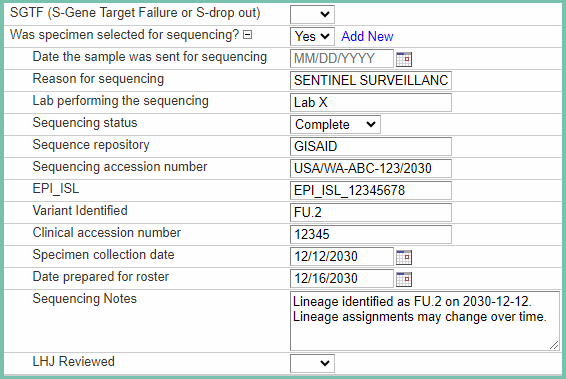
<figcaption>Figure 8</figcaption>
</figure>

## For Review

The pipeline attempts to link sequencing data to cases in WDRS. Some records have quality issues and cannot be processed in our system. These data are tagged and saved in a separate folder where our team reviews them and attempts to fix and re-process them. <a href="#tbl-review" class="quarto-xref">Table 5</a> is an example of the sort of issues that get tagged in our pipeline:

| Variable         | Description                                                 |
|------------------------------------|------------------------------------|
| QA_CASE_ID       | Missing CASE_ID from WDRS                                   |
| QA_SCA_NA        | Clinical Accession identifier is missing                    |
| QA_SCA_INT_DUPE  | Clinical Accession duplicate in file                        |
| QA_SCA_WDRS_DUPE | Clinical Accession duplicate found in WDRS                  |
| QA_SA_INT_DUPE   | Accession duplicate in file                                 |
| QA_SA_WDRS_DUPE  | Accession duplicate found in WDRS                           |
| QA_SEQ_VARIANT   | Variant not in list of VOC                                  |
| QA_SEQ_STAT      | Status error (labeled complete sequence when it was failed) |
| QA_SEQ_REASON    | Unknown sequence reason                                     |
| QA_SEQ_NOTES     | Sequence note not formatted                                 |
| QA_COLLECT_DATE  | Match found but collection dates \>14 days                  |
| QA_OTHER         | Other formatting issues                                     |
| sum              | Total number of errors found                                |

Table 5: For review quality issue tags

## Fuzzy Matching Review

When records cannot be linked via accession identifier the pipeline attempts to match a sequence to a PCR test in WDRS via demographics (first name, last name, date of birth, and collection date). The [fuzzy matching script](notebook/fuzzy.Rmd) uses [string distances](https://github.com/markvanderloo/stringdist) to match names from a submitter to names in WDRS and determine the highest likelihood of a correct link.

There may be quality issues with the demographics and the fuzzy matching script tags issues and outputs them into a fuzzy matching review folder where our team will manually review the errors and re-process the files. <a href="#tbl-fuzzyreview" class="quarto-xref">Table 6</a> is an example of the files the fuzzy matching process outputs:

| File           | Description                                       |
|----------------|---------------------------------------------------|
| Fuzzy bad rows | error in a column other than demographics columns |
| Fuzz 1         | best match was a name levenshtein distance of 1   |
| Fuzz 2         | best match was a name levenshtein distance of 2   |
| Fuzz 3         | best match was a name levenshtein distance of 3   |
| Did_not_match  | no match was found                                |
| Fuzzy perfect  | perfect match found                               |

Table 6: Fuzzy matching review quality issue tags

## Keep NA

A sequenced specimen may not initially match to our database (WDRS) for many reasons. A case may not have been updated at the time our pipeline tried to match the sequence to the PCR test, or a sequence may simply not match to a case in WDRS. Our [Keep NA script](KEEP_NA_ROSTER_SECOND_IN_PROGRESS.Rmd) reads in all the data that could not be matched in previous pipeline runs and attempts to match them again in the case that new and updated case data is in WDRS. If an unmatched record is in our archive for more than 60 days the Keep NA script will remove it from the list and keep it in an archived file. We made this decision because the vast majority of records that are in Keep NA for over 60 days have never matched to any case in WDRS.

# QA Processes

## Gap data

**gap_data.Rmd** performs the task of identifying and tracking the number of sequencing records for the state of WA that have been submitted to GISAID but are missing from WDRS. As previously mentioned, submitters should be sending records to both the DOH and GISAID. This process uses the `SEQUENCE_ACCESION` (`GISAID_ID`) to identify any records from GISAID that are not in WDRS for the state of WA. An excel file containing two pivot tables and metadata is output. Each pivot table contains either the number or proportion of records missing in WDRS, this information is the submission date (month-year) and the submitting lab. The metadata contains each record and accompanying information pulled from GISAID.

This output is utilized by Data Support and other stakeholders for two main reasons. First, to reach out to submitters to regarding missing records. Second, to identify any new that are submitting to GISAID regularly and should potentially be onboarded.

## WDRS Logic Checks

`wdrs_logic_checks.R` pulls the sequencing data from our database and runs checks on them to confirm that there are no issues with the data uploaded. See <a href="#tbl-qachecks" class="quarto-xref">Table 7</a> below for more info.

| QA Check                                                                               | Description                                                                                    |
|--------------------------------------|----------------------------------|
| SEQUENCE_REASON is NULL                                                                | The reason for sequencing is used to determine sentinel surveillance counts and cannot be null |
| SEQUENCE_REASON not standardized                                                       | If the reason has a typo or unexpected value                                                   |
| SEQUENCE_VARIANT_OPEN_TEXT filled but SEQUENCE_STATUS is not COMPLETE                  | Status must be complete when the variant is filled                                             |
| SEQUENCE_ACCESSION number NULL but status not FAILED/LOW QUALITY                       | A sequence identifier must be provided for complete sequences                                  |
| SEQUENCE_VARIANT_OPEN_TEXT exists but SEQUENCE_ACCESION number is null                 | A sequence identifier must be provided for sequences with lineage calls                        |
| SEQUENCE_VARIANT not of concern/interest - check or update list                        | Lineage has a typo or not a variant of concern                                                 |
| SEQUENCE_LAB not standardized - check or update list                                   | The lab name is not standardized to our database standards                                     |
| SEQUENCE_SPECIMEN_COLLECTION_DATE out of range. Before 1/05/2020 or after today’s date | The sequence collection date is in the future or before 2020 (invalid)                         |
| SEQUENCE_SPECIMEN = ‘No’ but sequencing data attatched                                 | Database error                                                                                 |
| SEQUENCE_ACCESSION number and SEQUENCE_CLINICAL_ACCESSION numbers missing              | A sequence needs the identifiers attached                                                      |
| Unexpected characters in a column                                                      | Database or submitter error (usually typos or wrong value in a column)                         |
| Lineage found in SEQUENCE_NOTES but SEQUENCE_VARIANT_OPEN_TEXT is NULL                 | Database error                                                                                 |
| SEQUENCE_STATUS = ‘Complete’ and SEQUENCE_VARIANT_OPEN_TEXT is NULL                    | Sequence needs a lineage call if status is complete                                            |
| Duplicate - SCA, SA and Variant duplicated                                             | Duplicate identifier values found in database                                                  |

Table 7: WDRS QA Checks

# Results

During the February 2021 to September 2023 period we processed a total of 172,050 sequences. These data were most commonly processed via SFT (secure file transfer) of tabular datasets (see <a href="#fig-countprop" class="quarto-xref">Figure 9</a> below)

``` python
library(patchwork)

(prop_plot + count_plot) + 
  plot_layout(guides="collect", axes = "collect_x") +
  plot_annotation(
    title = 'Sars CoV-2 Sequencing Metadata Submissions by Mode',
    subtitle = 'Proportion and Counts',
    caption = 'Data collected from Feb. 2021 - Sep. 2023'
  )
```

<figure id="fig-countprop">
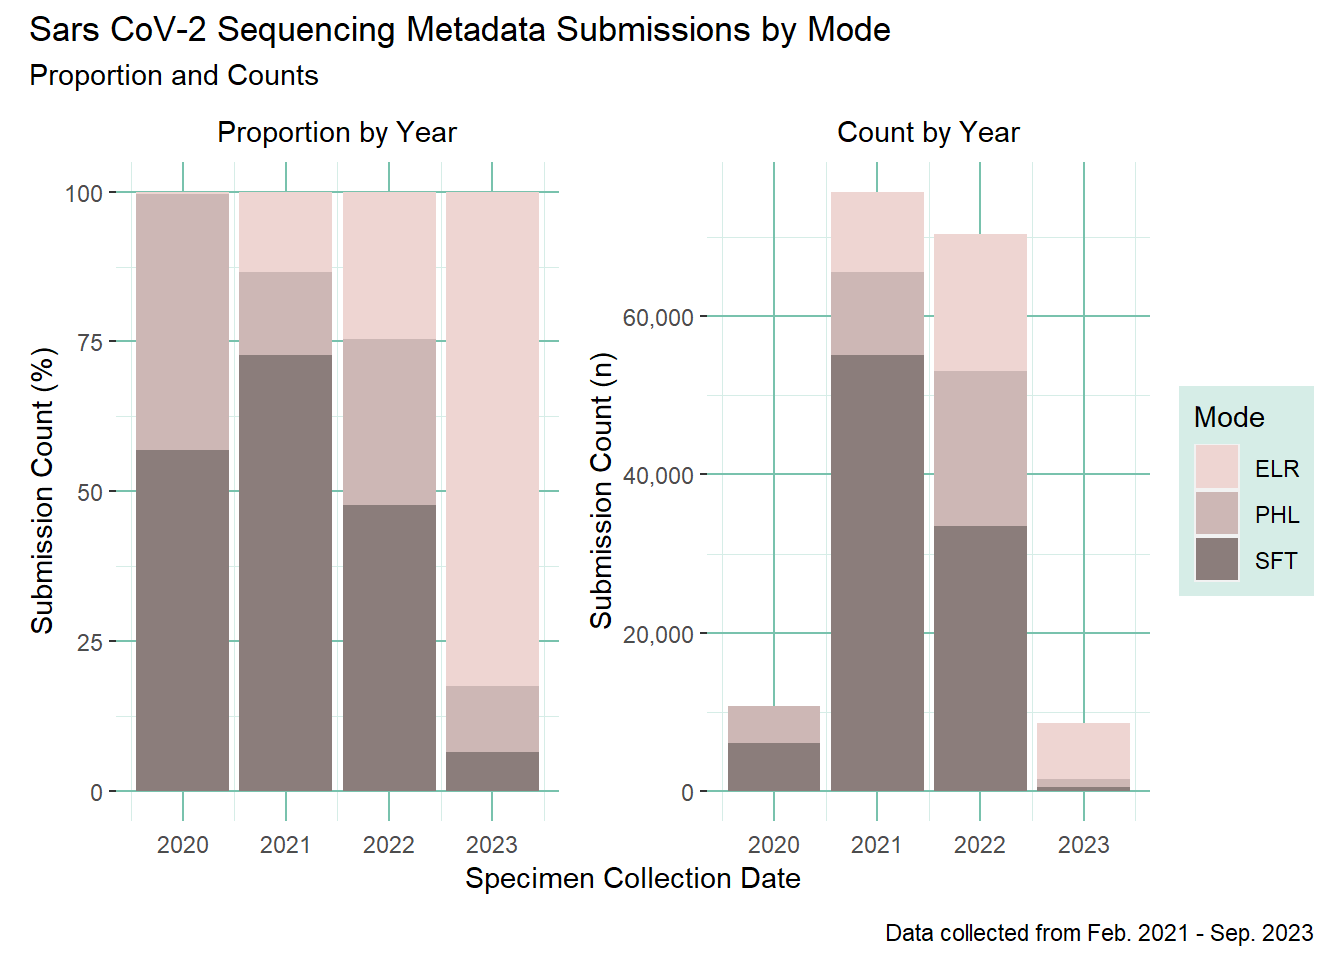
<figcaption>Figure 9: Count and proportion of sequencing metadata submissions by mode</figcaption>
</figure>

96% of those sequences were successfully matched to a case in WDRS, while 3% had no match. Less than 1% of the records had quality issues that could not be resolved and are still archived in our for review process. See <a href="#tbl-counts" class="quarto-xref">Table 8</a> for more details.

``` python
# ------ Create Final Table of Counts ------ #

# Get the Counts
pipeline_counts <- tribble(
  ~Location, ~Count,
  "For Review", for_review_count,
  "Fuzzy Review", fuzzy_count,
  "Keep NA", keep_na_count,
  "WDRS", wdrs_count) %>%
  # Get the Percents
  mutate(freq = scales::label_percent()(Count / sum(Count))) %>%
  # Get the Totals
  janitor::adorn_totals()

# Take the counts and put them in a table.

# use the gt table for html stuff
  # Convert to a GT table and style it
(gt_counts <- pipeline_counts %>%
  gt() %>%
  cols_merge_n_pct(
    col_n = Count,
    col_pct = freq
  ) %>%
  fmt_number(
    columns = Count,
    decimals = 0,
    use_seps = T
  ) %>%
  # Highlight the WDRS row
  gt_highlight_rows(
     rows = Location == "WDRS",
     fill = "#8b7d7b",
     bold_target_only = TRUE,
     target_col = Count
   ) %>%
  cols_align("left") %>%
  tab_header(title = 
               md("Covid Sequencing Pipeline Counts")) %>%
  style_table()
)
#| label: tbl-counts
#| tbl-cap: "Count of sequences matching to WDRS cases"
# make a kable table - these are the only tables that can be output with a manuscript project
# pipeline_counts %>% 
#   mutate(Count = paste0(Count," (",freq,")")) %>% 
#   select(-freq) %>%
#   knitr::kable()
```

<div id="gzagugjuxk" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
<style>@import url("https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,200;0,300;0,400;0,500;0,600;0,700;0,800;0,900;1,100;1,200;1,300;1,400;1,500;1,600;1,700;1,800;1,900&display=swap");
#gzagugjuxk table {
  font-family: Roboto, system-ui, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#gzagugjuxk thead, #gzagugjuxk tbody, #gzagugjuxk tfoot, #gzagugjuxk tr, #gzagugjuxk td, #gzagugjuxk th {
  border-style: none;
}

#gzagugjuxk p {
  margin: 0;
  padding: 0;
}

#gzagugjuxk .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #000000;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #000000;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
}

#gzagugjuxk .gt_caption {
  padding-top: 4px;
  padding-bottom: 4px;
}

#gzagugjuxk .gt_title {
  color: #333333;
  font-size: 125%;
  font-weight: initial;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-color: #FFFFFF;
  border-bottom-width: 0;
}

#gzagugjuxk .gt_subtitle {
  color: #333333;
  font-size: 85%;
  font-weight: initial;
  padding-top: 3px;
  padding-bottom: 5px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-color: #FFFFFF;
  border-top-width: 0;
}

#gzagugjuxk .gt_heading {
  background-color: #FFFFFF;
  text-align: left;
  border-bottom-color: #FFFFFF;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#gzagugjuxk .gt_bottom_border {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#gzagugjuxk .gt_col_headings {
  border-top-style: solid;
  border-top-width: 3px;
  border-top-color: #000000;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#gzagugjuxk .gt_col_heading {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  text-transform: uppercase;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 6px;
  padding-left: 5px;
  padding-right: 5px;
  overflow-x: hidden;
}

#gzagugjuxk .gt_column_spanner_outer {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  text-transform: uppercase;
  padding-top: 0;
  padding-bottom: 0;
  padding-left: 4px;
  padding-right: 4px;
}

#gzagugjuxk .gt_column_spanner_outer:first-child {
  padding-left: 0;
}

#gzagugjuxk .gt_column_spanner_outer:last-child {
  padding-right: 0;
}

#gzagugjuxk .gt_column_spanner {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 5px;
  overflow-x: hidden;
  display: inline-block;
  width: 100%;
}

#gzagugjuxk .gt_spanner_row {
  border-bottom-style: hidden;
}

#gzagugjuxk .gt_group_heading {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  text-transform: uppercase;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  text-align: left;
}

#gzagugjuxk .gt_empty_group_heading {
  padding: 0.5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: middle;
}

#gzagugjuxk .gt_from_md > :first-child {
  margin-top: 0;
}

#gzagugjuxk .gt_from_md > :last-child {
  margin-bottom: 0;
}

#gzagugjuxk .gt_row {
  padding-top: 3px;
  padding-bottom: 3px;
  padding-left: 10px;
  padding-right: 10px;
  margin: 10px;
  border-top-style: solid;
  border-top-width: 1px;
  border-top-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  overflow-x: hidden;
}

#gzagugjuxk .gt_stub {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  text-transform: uppercase;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 10px;
  padding-right: 10px;
}

#gzagugjuxk .gt_stub_row_group {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 5px;
  padding-right: 5px;
  vertical-align: top;
}

#gzagugjuxk .gt_row_group_first td {
  border-top-width: 2px;
}

#gzagugjuxk .gt_row_group_first th {
  border-top-width: 2px;
}

#gzagugjuxk .gt_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#gzagugjuxk .gt_first_summary_row {
  border-top-style: solid;
  border-top-color: #D3D3D3;
}

#gzagugjuxk .gt_first_summary_row.thick {
  border-top-width: 2px;
}

#gzagugjuxk .gt_last_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#gzagugjuxk .gt_grand_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#gzagugjuxk .gt_first_grand_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-style: double;
  border-top-width: 6px;
  border-top-color: #D3D3D3;
}

#gzagugjuxk .gt_last_grand_summary_row_top {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: double;
  border-bottom-width: 6px;
  border-bottom-color: #D3D3D3;
}

#gzagugjuxk .gt_striped {
  background-color: rgba(128, 128, 128, 0.05);
}

#gzagugjuxk .gt_table_body {
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#gzagugjuxk .gt_footnotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#gzagugjuxk .gt_footnote {
  margin: 0px;
  font-size: 90%;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#gzagugjuxk .gt_sourcenotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#gzagugjuxk .gt_sourcenote {
  font-size: 12px;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#gzagugjuxk .gt_left {
  text-align: left;
}

#gzagugjuxk .gt_center {
  text-align: center;
}

#gzagugjuxk .gt_right {
  text-align: right;
  font-variant-numeric: tabular-nums;
}

#gzagugjuxk .gt_font_normal {
  font-weight: normal;
}

#gzagugjuxk .gt_font_bold {
  font-weight: bold;
}

#gzagugjuxk .gt_font_italic {
  font-style: italic;
}

#gzagugjuxk .gt_super {
  font-size: 65%;
}

#gzagugjuxk .gt_footnote_marks {
  font-size: 75%;
  vertical-align: 0.4em;
  position: initial;
}

#gzagugjuxk .gt_asterisk {
  font-size: 100%;
  vertical-align: 0;
}

#gzagugjuxk .gt_indent_1 {
  text-indent: 5px;
}

#gzagugjuxk .gt_indent_2 {
  text-indent: 10px;
}

#gzagugjuxk .gt_indent_3 {
  text-indent: 15px;
}

#gzagugjuxk .gt_indent_4 {
  text-indent: 20px;
}

#gzagugjuxk .gt_indent_5 {
  text-indent: 25px;
}
</style>

| Covid Sequencing Pipeline Counts |                  |
|----------------------------------|------------------|
| Location                         | Count            |
| For Review                       | 220 (0.13%)      |
| Fuzzy Review                     | 569 (0.33%)      |
| Keep NA                          | 5,710 (3.32%)    |
| WDRS                             | 165,551 (96.22%) |
| Total                            | 172,050 (-)      |

</div>

Table 8: Count of sequences matching to WDRS cases

When stratifying by lab/submitter in <a href="#tbl-labcount" class="quarto-xref">Table 9</a>, we can see that most of the sequences were submitted by 4 labs. Over 40% of the sequences were submitted by University of Washington Virology Lab, followed by our own PHL with 19%, Labcorp with 15% and Northwest Genomics with 11%.

``` python
(count_by_lab <- wdrs_seq %>%
  count(SEQUENCE_LAB) %>%
  arrange(desc(n)) %>%
  summarize(
    n,
    x_scaled = n / nrow(wdrs_seq) * 100,
    .by = SEQUENCE_LAB
  ) %>%
  gt() %>%
  gt_plt_bar_pct(
    column = x_scaled,
    scaled = TRUE,
    labels = TRUE,
    font_size = "12px",
    fill = "#8b7d7b"
  ) %>%
  tab_header(title = md("Number of Sequences by Lab"),
             subtitle = md("Before 2023-06-01 switch to 2.0 pipeline")) %>%
  fmt_number(
    columns = n,
    decimals = 0,
    use_seps = T
  ) %>%
  cols_label(
    SEQUENCE_LAB = 'Sequencing Lab',
    n = 'Count',
    x_scaled = 'Percent of Total Sequences'
  ) %>%
  style_table()
)
```

<div id="itithtszcp" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
<style>@import url("https://fonts.googleapis.com/css2?family=Roboto:ital,wght@0,100;0,200;0,300;0,400;0,500;0,600;0,700;0,800;0,900;1,100;1,200;1,300;1,400;1,500;1,600;1,700;1,800;1,900&display=swap");
#itithtszcp table {
  font-family: Roboto, system-ui, 'Segoe UI', Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#itithtszcp thead, #itithtszcp tbody, #itithtszcp tfoot, #itithtszcp tr, #itithtszcp td, #itithtszcp th {
  border-style: none;
}

#itithtszcp p {
  margin: 0;
  padding: 0;
}

#itithtszcp .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #000000;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #000000;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
}

#itithtszcp .gt_caption {
  padding-top: 4px;
  padding-bottom: 4px;
}

#itithtszcp .gt_title {
  color: #333333;
  font-size: 125%;
  font-weight: initial;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-color: #FFFFFF;
  border-bottom-width: 0;
}

#itithtszcp .gt_subtitle {
  color: #333333;
  font-size: 85%;
  font-weight: initial;
  padding-top: 3px;
  padding-bottom: 5px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-color: #FFFFFF;
  border-top-width: 0;
}

#itithtszcp .gt_heading {
  background-color: #FFFFFF;
  text-align: left;
  border-bottom-color: #FFFFFF;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#itithtszcp .gt_bottom_border {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#itithtszcp .gt_col_headings {
  border-top-style: solid;
  border-top-width: 3px;
  border-top-color: #000000;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#itithtszcp .gt_col_heading {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  text-transform: uppercase;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 6px;
  padding-left: 5px;
  padding-right: 5px;
  overflow-x: hidden;
}

#itithtszcp .gt_column_spanner_outer {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  text-transform: uppercase;
  padding-top: 0;
  padding-bottom: 0;
  padding-left: 4px;
  padding-right: 4px;
}

#itithtszcp .gt_column_spanner_outer:first-child {
  padding-left: 0;
}

#itithtszcp .gt_column_spanner_outer:last-child {
  padding-right: 0;
}

#itithtszcp .gt_column_spanner {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 5px;
  overflow-x: hidden;
  display: inline-block;
  width: 100%;
}

#itithtszcp .gt_spanner_row {
  border-bottom-style: hidden;
}

#itithtszcp .gt_group_heading {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  text-transform: uppercase;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  text-align: left;
}

#itithtszcp .gt_empty_group_heading {
  padding: 0.5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: middle;
}

#itithtszcp .gt_from_md > :first-child {
  margin-top: 0;
}

#itithtszcp .gt_from_md > :last-child {
  margin-bottom: 0;
}

#itithtszcp .gt_row {
  padding-top: 3px;
  padding-bottom: 3px;
  padding-left: 10px;
  padding-right: 10px;
  margin: 10px;
  border-top-style: solid;
  border-top-width: 1px;
  border-top-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  overflow-x: hidden;
}

#itithtszcp .gt_stub {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 80%;
  font-weight: bolder;
  text-transform: uppercase;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 10px;
  padding-right: 10px;
}

#itithtszcp .gt_stub_row_group {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 5px;
  padding-right: 5px;
  vertical-align: top;
}

#itithtszcp .gt_row_group_first td {
  border-top-width: 2px;
}

#itithtszcp .gt_row_group_first th {
  border-top-width: 2px;
}

#itithtszcp .gt_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#itithtszcp .gt_first_summary_row {
  border-top-style: solid;
  border-top-color: #D3D3D3;
}

#itithtszcp .gt_first_summary_row.thick {
  border-top-width: 2px;
}

#itithtszcp .gt_last_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#itithtszcp .gt_grand_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#itithtszcp .gt_first_grand_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-style: double;
  border-top-width: 6px;
  border-top-color: #D3D3D3;
}

#itithtszcp .gt_last_grand_summary_row_top {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: double;
  border-bottom-width: 6px;
  border-bottom-color: #D3D3D3;
}

#itithtszcp .gt_striped {
  background-color: rgba(128, 128, 128, 0.05);
}

#itithtszcp .gt_table_body {
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#itithtszcp .gt_footnotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#itithtszcp .gt_footnote {
  margin: 0px;
  font-size: 90%;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#itithtszcp .gt_sourcenotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#itithtszcp .gt_sourcenote {
  font-size: 12px;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#itithtszcp .gt_left {
  text-align: left;
}

#itithtszcp .gt_center {
  text-align: center;
}

#itithtszcp .gt_right {
  text-align: right;
  font-variant-numeric: tabular-nums;
}

#itithtszcp .gt_font_normal {
  font-weight: normal;
}

#itithtszcp .gt_font_bold {
  font-weight: bold;
}

#itithtszcp .gt_font_italic {
  font-style: italic;
}

#itithtszcp .gt_super {
  font-size: 65%;
}

#itithtszcp .gt_footnote_marks {
  font-size: 75%;
  vertical-align: 0.4em;
  position: initial;
}

#itithtszcp .gt_asterisk {
  font-size: 100%;
  vertical-align: 0;
}

#itithtszcp .gt_indent_1 {
  text-indent: 5px;
}

#itithtszcp .gt_indent_2 {
  text-indent: 10px;
}

#itithtszcp .gt_indent_3 {
  text-indent: 15px;
}

#itithtszcp .gt_indent_4 {
  text-indent: 20px;
}

#itithtszcp .gt_indent_5 {
  text-indent: 25px;
}
</style>

<table class="gt_table do-not-create-environment cell" data-quarto-postprocess="true" style="table-layout: fixed;" data-quarto-disable-processing="false" data-quarto-bootstrap="false">
<thead>
<tr class="header gt_heading">
<th colspan="3" class="gt_heading gt_title gt_font_normal">Number of Sequences by Lab</th>
</tr>
<tr class="odd gt_heading">
<th colspan="3" class="gt_heading gt_subtitle gt_font_normal gt_bottom_border">Before 2023-06-01 switch to 2.0 pipeline</th>
</tr>
<tr class="header gt_col_headings">
<th id="Sequencing Lab" class="gt_col_heading gt_columns_bottom_border gt_left" data-quarto-table-cell-role="th" style="border-bottom-width: 3px; border-bottom-style: solid; border-bottom-color: black" scope="col">Sequencing Lab</th>
<th id="Count" class="gt_col_heading gt_columns_bottom_border gt_right" data-quarto-table-cell-role="th" style="border-bottom-width: 3px; border-bottom-style: solid; border-bottom-color: black" scope="col">Count</th>
<th id="Percent of Total Sequences" class="gt_col_heading gt_columns_bottom_border gt_left" data-quarto-table-cell-role="th" style="border-bottom-width: 3px; border-bottom-style: solid; border-bottom-color: black" scope="col">Percent of Total Sequences</th>
</tr>
</thead>
<tbody class="gt_table_body">
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">UW Virology</td>
<td class="gt_row gt_right" headers="n">69,799</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:42.1616299508913%;height:16px;display:flex;align-items:center;justify-content:flex-start;position:relative;">
<span style="color:#000000;position:absolute;left:0px;margin-left:5px;font-weight:bold;font-size:12px;">42.2%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">PHL</td>
<td class="gt_row gt_right" headers="n">32,845</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:19.8398076725601%;height:16px;display:flex;align-items:center;justify-content:flex-start;position:relative;">
<span style="color:#000000;position:absolute;left:0px;margin-left:5px;font-weight:bold;font-size:12px;">19.8%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Labcorp</td>
<td class="gt_row gt_right" headers="n">26,597</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:16.0657440909448%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:16.0657440909448px;font-weight:bold;font-size:12px;">16.1%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">NW Genomics</td>
<td class="gt_row gt_right" headers="n">18,532</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:11.1941335298488%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:11.1941335298488px;font-weight:bold;font-size:12px;">11.2%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Quest</td>
<td class="gt_row gt_right" headers="n">4,121</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:2.48926312737465%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:2.48926312737465px;font-weight:bold;font-size:12px;">2.5%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Altius</td>
<td class="gt_row gt_right" headers="n">3,696</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:2.2325446539133%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:2.2325446539133px;font-weight:bold;font-size:12px;">2.2%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Fulgent Genetics</td>
<td class="gt_row gt_right" headers="n">2,859</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:1.72696027206118%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:1.72696027206118px;font-weight:bold;font-size:12px;">1.7%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">PHL/Bedford</td>
<td class="gt_row gt_right" headers="n">2,857</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:1.72575218512724%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:1.72575218512724px;font-weight:bold;font-size:12px;">1.7%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">SCAN/Bedford</td>
<td class="gt_row gt_right" headers="n">1,004</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.606459640835755%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.606459640835755px;font-weight:bold;font-size:12px;">0.6%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Aegis</td>
<td class="gt_row gt_right" headers="n">943</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.569612989350714%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.569612989350714px;font-weight:bold;font-size:12px;">0.6%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Curative Labs</td>
<td class="gt_row gt_right" headers="n">649</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.392024210062156%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.392024210062156px;font-weight:bold;font-size:12px;">0.4%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">KP WA Research Inst</td>
<td class="gt_row gt_right" headers="n">281</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.169736214217975%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.169736214217975px;font-weight:bold;font-size:12px;">0.2%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">USAFSAM</td>
<td class="gt_row gt_right" headers="n">275</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.166111953416168%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.166111953416168px;font-weight:bold;font-size:12px;">0.2%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">CDC</td>
<td class="gt_row gt_right" headers="n">211</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.127453171530223%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.127453171530223px;font-weight:bold;font-size:12px;">0.1%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Providence Swedish</td>
<td class="gt_row gt_right" headers="n">173</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.104499519785444%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.104499519785444px;font-weight:bold;font-size:12px;">0.1%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Helix</td>
<td class="gt_row gt_right" headers="n">151</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0912105635121503%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0912105635121503px;font-weight:bold;font-size:12px;">0.1%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Lauring Lab</td>
<td class="gt_row gt_right" headers="n">118</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0712771291022102%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0712771291022102px;font-weight:bold;font-size:12px;">0.1%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Atlas Genomics</td>
<td class="gt_row gt_right" headers="n">89</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0537598685601416%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0537598685601416px;font-weight:bold;font-size:12px;">0.1%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Boise VA</td>
<td class="gt_row gt_right" headers="n">67</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0404709122868482%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0404709122868482px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">OHSU</td>
<td class="gt_row gt_right" headers="n">61</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0368466514850409%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0368466514850409px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">SFS/Bedford</td>
<td class="gt_row gt_right" headers="n">53</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0320143037492978%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0320143037492978px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">IDBOL</td>
<td class="gt_row gt_right" headers="n">40</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0241617386787153%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0241617386787153px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Gravity Diagnostics</td>
<td class="gt_row gt_right" headers="n">36</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0217455648108438%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0217455648108438px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">ASU</td>
<td class="gt_row gt_right" headers="n">33</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0199334344099401%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0199334344099401px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">NA</td>
<td class="gt_row gt_right" headers="n">18</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.0108727824054219%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.0108727824054219px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">OSPHL</td>
<td class="gt_row gt_right" headers="n">15</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.00906065200451824%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.00906065200451824px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">USAMRIID</td>
<td class="gt_row gt_right" headers="n">9</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.00543639120271095%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.00543639120271095px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Infinity Biologix</td>
<td class="gt_row gt_right" headers="n">7</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.00422830426877518%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.00422830426877518px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Grubaugh Lab</td>
<td class="gt_row gt_right" headers="n">2</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.00120808693393577%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.00120808693393577px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Montana Public Health Lab</td>
<td class="gt_row gt_right" headers="n">2</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.00120808693393577%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.00120808693393577px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Flow Diagnostics</td>
<td class="gt_row gt_right" headers="n">1</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.000604043466967883%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.000604043466967883px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Grittman Medical Center</td>
<td class="gt_row gt_right" headers="n">1</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.000604043466967883%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.000604043466967883px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">NW GENOMICS</td>
<td class="gt_row gt_right" headers="n">1</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.000604043466967883%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.000604043466967883px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Naval Health Research Center</td>
<td class="gt_row gt_right" headers="n">1</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.000604043466967883%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.000604043466967883px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">Providence_Swedish</td>
<td class="gt_row gt_right" headers="n">1</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.000604043466967883%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.000604043466967883px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">SCAB/Bedford</td>
<td class="gt_row gt_right" headers="n">1</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.000604043466967883%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.000604043466967883px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="odd">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">SFS/ Bedford</td>
<td class="gt_row gt_right" headers="n">1</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.000604043466967883%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.000604043466967883px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
<tr class="even">
<td class="gt_row gt_left" headers="SEQUENCE_LAB">The Jackson Laboratory</td>
<td class="gt_row gt_right" headers="n">1</td>
<td class="gt_row gt_left" headers="x_scaled"><div style="flex-grow:1;margin-left:8px;background:#e1e1e1;">
<div style="background:#8b7d7b;width:0.000604043466967883%;height:16px;display:flex;align-items:center;justify-content:center;color:#000000;font-weight:bold;font-size:12px;position:relative;">
<span style="color:#000000;position:absolute;left:0%;margin-left:0.000604043466967883px;font-weight:bold;font-size:12px;">0%</span>
</div>
</div></td>
</tr>
</tbody>
</table>

</div>

Table 9: Count of sequences by lab and status during the sequencing pipeline 1.0 phase

[source notebook](notebooks/pipeline_counts.qmd#tbl-labcount).

<br>

Oltean, Hanna N., Krisandra J. Allen, Lauren Frisbie, Stephanie M. Lunn, Laura Marcela Torres, Lillian Manahan, Ian Painter, et al. n.d. “Sentinel Surveillance System Implementation and Evaluation for SARS-CoV-2 Genomic Data, Washington, USA, 2020–2021 - Volume 29, Number 2—February 2023 - Emerging Infectious Diseases Journal - CDC.” Accessed March 18, 2024. <https://doi.org/10.3201/eid2902.221482>.

Oltean, Hanna N., Allison Black, Stephanie M. Lunn, Nailah Smith, Allison Templeton, Elyse Bevers, Lynae Kibiger, et al. 2024. “Changing Genomic Epidemiology of COVID-19 in Long-Term Care Facilities During the 2020–2022 Pandemic, Washington State.” *BMC Public Health* 24 (January): 182. <https://doi.org/10.1186/s12889-023-17461-2>.

Wagner, Cassia, Kathryn E. Kistler, Garrett A. Perchetti, Noah Baker, Lauren A. Frisbie, Laura Marcela Torres, Frank Aragona, et al. 2023. “Positive Selection Underlies Repeated Knockout of ORF8 in SARS-CoV-2 Evolution.” September 23, 2023. <https://doi.org/10.1101/2023.09.21.23295927>.